In [132]:
import pandas as pd
import numpy as np
from itables import show
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# ajouter le dossier src au path
BASE_DIR = Path().resolve().parent.parent

sys.path.append(str(BASE_DIR))

from src.config.config_path import APPROS_RAW, STOCK_RAW, VENTES_RAW

# Analyse exploratoire rapide des jeux de données

## 1. Données Stocks

#### a) Infos globales

In [75]:
df_ana = pd.read_csv(STOCK_RAW)
display(df_ana.info())
display(df_ana.describe())
show(df_ana)

<class 'pandas.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code_article  223 non-null    int64  
 1   code_site     223 non-null    str    
 2   quantite      223 non-null    float64
dtypes: float64(1), int64(1), str(1)
memory usage: 5.4 KB


None

,code_article,quantite
count,223.000000,223.000000
mean,1411.349776,3410.246699
std,357.663997,6332.628476
min,42.000000,1.000000
25%,1290.000000,327.000000
50%,1571.000000,978.000000
75%,1659.500000,3507.000000
max,1811.000000,43200.000000


Loading ITables v2.7.0 from the internet... (need help?)


#### b) Test doublons

In [76]:
df_ana['dbl'] = df_ana.duplicated()
show(df_ana['dbl'].value_counts().reset_index())

Loading ITables v2.7.0 from the internet... (need help?)


#### c) Fonctionnement stocks

In [77]:
## Nombre de lignes par code article
cle = ['code_article']
print("Nombre de lignes par code article")
df_test = df_ana.groupby(cle, as_index=False).agg(nb_lignes=('quantite', 'count'))
show(df_test['nb_lignes'].value_counts().reset_index())

## Nombre de lignes par code article & site
cle = ['code_article', 'code_site']
print("\nNombre de lignes par code article & site")
df_test = df_ana.groupby(cle, as_index=False).agg(nb_lignes=('quantite', 'count'))
show(df_test['nb_lignes'].value_counts().reset_index())

## Affichage des articles "multi lignes"
print("\nAffichage des articles multi-sites")
show(df_ana[df_ana.groupby('code_article')['quantite'].transform('count') > 1])

Nombre de lignes par code article


Loading ITables v2.7.0 from the internet... (need help?)



Nombre de lignes par code article & site


Loading ITables v2.7.0 from the internet... (need help?)



Affichage des articles multi-sites


Loading ITables v2.7.0 from the internet... (need help?)


#### d) Test des formats

In [78]:
## Variable quantité : float / int

# Test si valeur entière
df_ana['entier'] = (df_ana['quantite'] % 1 == 0)
show(df_ana['entier'].value_counts(normalize = True).reset_index())

Loading ITables v2.7.0 from the internet... (need help?)


#### e) Analyse des variables

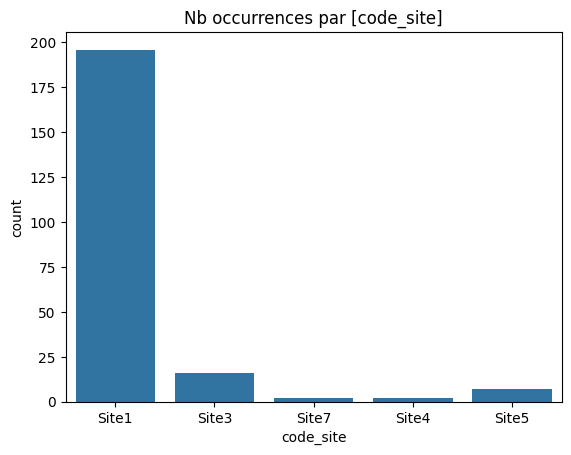

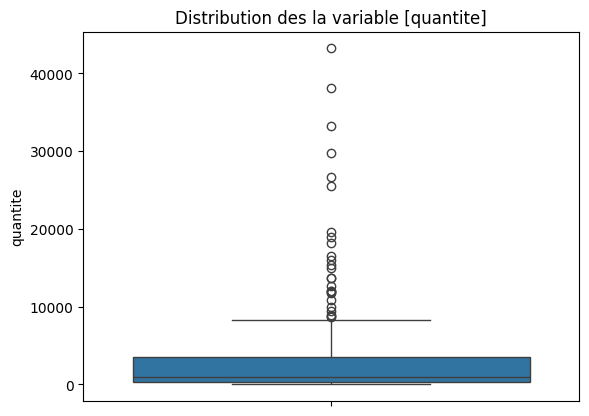

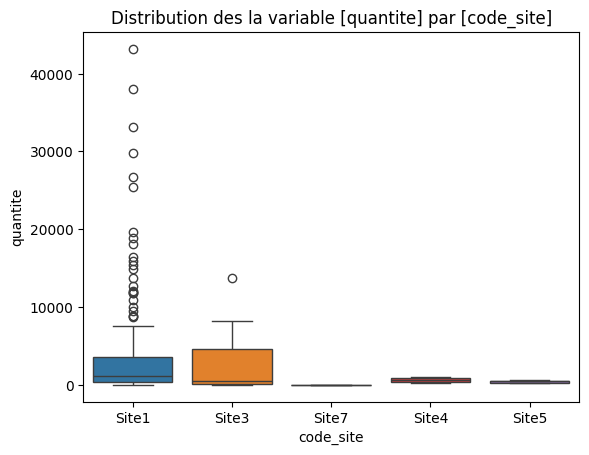

In [79]:
## Analyse de la variable qualitative [code_site]
sns.countplot(x='code_site', data=df_ana)
plt.title("Nb occurrences par [code_site]")
plt.show()
# show(df_ana['code_site'].value_counts())

## Analyse de la variable quantitative [quantite] 
sns.boxplot(y = df_ana['quantite'])
plt.title("Distribution des la variable [quantite]")
plt.show()

sns.boxplot(y = 'quantite', x='code_site', hue='code_site', data=df_ana)
plt.title("Distribution des la variable [quantite] par [code_site]")
plt.show()

In [80]:
## Sauvegarde du dataframe pour croisement champs communs avec autres tables
df_stocks = df_ana.copy()
df_stocks['src_stocks'] = True

## 2. Données appros

#### a) Infos globales

In [121]:
df_ana = pd.read_csv(APPROS_RAW)
display(df_ana.info())
display(df_ana.describe())
show(df_ana)

<class 'pandas.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   code_article  372 non-null    str  
 1   code_site     372 non-null    str  
 2   quantite      372 non-null    int64
 3   date          372 non-null    str  
dtypes: int64(1), str(3)
memory usage: 11.8 KB


None

,quantite
count,372.000000
mean,1639.709677
std,1856.525866
min,1.000000
25%,427.500000
50%,1200.000000
75%,1707.250000
max,7500.000000


Loading ITables v2.7.0 from the internet... (need help?)


#### b) Test doublons

In [122]:
cols = df_ana.columns.tolist()

df_ana['dbl'] = df_ana.duplicated(subset=cols)
show(df_ana['dbl'].value_counts().reset_index())

# Test pour voir si problème sur un jour particulier
show(df_ana.groupby('date')['dbl'].sum().reset_index())

# Suppression des doublons pour suite analyse
# print(f"Nb lignes avant suppression : {len(df_ana)}")
# df_ana = df_ana.drop_duplicates(subset=cols)
# print(f"Nb lignes après suppression : {len(df_ana)}")

Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


#### c) Fonctionnement appros

In [123]:
## Nombre d'appros par jour et par clé article/site (hors doublons identifiés)
cle = ['date', 'code_article', 'code_site']
print("Nombre d'appros par jour et par clé article/site (hors doublons identifiés)")
cond = (~df_ana['dbl'])
df_test = df_ana[cond].groupby(cle, as_index=False).agg(nb_lignes=('quantite', 'count'))
show(df_test['nb_lignes'].value_counts().reset_index())

## Affichage des articles "multi lignes" (doublons compris)
print("\nAffichage des articles avec plusieurs appros la même journée")
show(df_ana[(df_ana.groupby(cle)['quantite'].transform('count') > 1)].sort_values(cle))


Nombre d'appros par jour et par clé article/site (hors doublons identifiés)


Loading ITables v2.7.0 from the internet... (need help?)



Affichage des articles avec plusieurs appros la même journée


Loading ITables v2.7.0 from the internet... (need help?)


#### d) Test des formats

In [124]:
## Variable code article : str

# Test que chaque caractère est bien numérique + calcul longueur
cond = (df_ana['code_article'].str.isnumeric())
df_ana['is_num'] = cond
df_ana['lg_code_art'] = df_ana['code_article'].str.strip().str.len()

show(df_ana['is_num'].value_counts())
show(df_ana['lg_code_art'].value_counts())

# Affichage code article non numérique
show(df_ana[~df_ana['is_num']])

# Conversion code article en int + suppression anomalie potentielle pour suite analyse
df_ana['code_article'] = (pd.to_numeric(df_ana['code_article'], errors='coerce')
                          .astype('Int64'))
print(f"Nb enregistrements avant supp {len(df_ana)}")
df_ana = df_ana[~df_ana['code_article'].isna()]
print(f"Nb enregistrements après supp {len(df_ana)}")


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Nb enregistrements avant supp 372
Nb enregistrements après supp 371


In [125]:
## Variable date : str

# Conversion champs date en datetime
df_ana['date_conv'] = pd.to_datetime(df_ana['date'], errors='coerce')

# Nb de valeurs avec erreurs conversion
print(f"Nb problème(s) conversion : {df_ana['date_conv'].isna().sum()}")

# Affichage des problèmes de conversion
show(df_ana[df_ana['date_conv'].isna()][['date', 'date_conv']].drop_duplicates())

Nb problème(s) conversion : 0


Loading ITables v2.7.0 from the internet... (need help?)


#### e) Analyse des variables

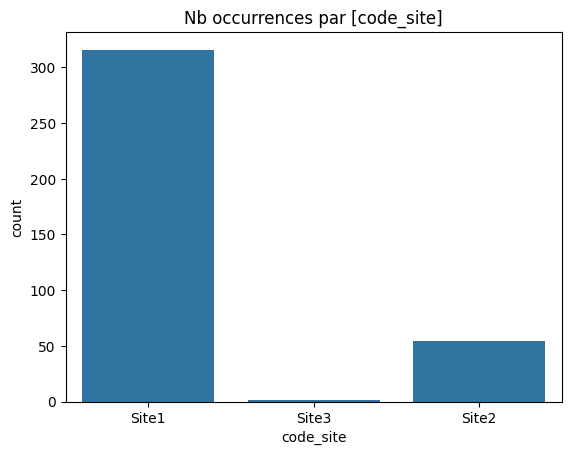

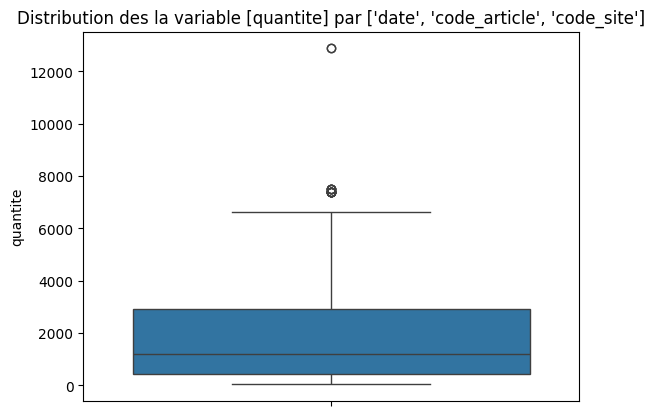

Loading ITables v2.7.0 from the internet... (need help?)


In [126]:
## Analyse de la variable qualitative [code_site]
sns.countplot(x='code_site', data=df_ana)
plt.title("Nb occurrences par [code_site]")
plt.show()
# show(df_ana['code_site'].value_counts())

## Analyse de la variable quantitative agrégée [quantite]
cle = ['date', 'code_article', 'code_site']
sns.boxplot(y = df_ana.groupby(cle, as_index=False)['quantite'].sum()['quantite'])
plt.title(f"Distribution des la variable [quantite] par {cle}")
plt.show()

## Affichage valeurs extrèmes
show((df_ana[(df_ana.groupby(cle)['quantite']
              .transform('sum') > 12000)]
              .sort_values(cle)))

In [127]:
## Sauvegarde du dataframe pour croisement champs communs avec autres tables
df_appros = df_ana.copy()
df_appros['src_appros'] = True

## 3. Données ventes

#### a) Infos globales

In [88]:
df_ana = pd.read_csv(VENTES_RAW)
display(df_ana.info())
display(df_ana.describe())
show(df_ana)

<class 'pandas.DataFrame'>
RangeIndex: 10246 entries, 0 to 10245
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code_article  10246 non-null  int64  
 1   code_site     10246 non-null  str    
 2   date          10246 non-null  str    
 3   quantite      10246 non-null  float64
dtypes: float64(1), int64(1), str(2)
memory usage: 320.3 KB


None

,code_article,quantite
count,10246.000000,10246.000000
mean,1413.623853,224.455063
std,361.492672,402.254397
min,42.000000,0.000000
25%,1291.000000,21.600000
50%,1561.500000,73.250000
75%,1672.000000,231.500000
max,1794.000000,3200.900000


Loading ITables v2.7.0 from the internet... (need help?)


#### b) Test doublons

In [89]:
df_ana['dbl'] = df_ana.duplicated()
show(df_ana['dbl'].value_counts().reset_index())

Loading ITables v2.7.0 from the internet... (need help?)


#### c) Fonctionnement ventes

In [90]:
## Nombre de ventes par jour et par clé article/site (hors doublons identifiés)
cle = ['date', 'code_article', 'code_site']
print("Nombre de ventes par jour et par clé article/site (hors doublons identifiés)")
cond = (~df_ana['dbl'])
df_test = df_ana[cond].groupby(cle, as_index=False).agg(nb_lignes=('quantite', 'count'))
show(df_test['nb_lignes'].value_counts().reset_index())

## Affichage des articles "multi lignes" (doublons compris)
print("\nAffichage des articles avec plusieurs ventes la même journée")
show(df_ana[(df_ana.groupby(cle)['quantite'].transform('count') > 1)].sort_values(cle))

Nombre de ventes par jour et par clé article/site (hors doublons identifiés)


Loading ITables v2.7.0 from the internet... (need help?)



Affichage des articles avec plusieurs ventes la même journée


Loading ITables v2.7.0 from the internet... (need help?)


#### d) Test des formats

In [91]:
## Variable quantité : float / int

# Test si valeur entière
df_ana['entier'] = (df_ana['quantite'] % 1 == 0)
show(df_ana['entier'].value_counts(normalize = True).reset_index())

Loading ITables v2.7.0 from the internet... (need help?)


In [92]:
## Variable date : str

# Conversion champs date en datetime
df_ana['date_conv'] = pd.to_datetime(df_ana['date'], errors='coerce')

# Nb de valeurs avec erreurs conversion
print(f"Nb problème(s) conversion : {df_ana['date_conv'].isna().sum()}")

# Affichage des problèmes de conversion
show(df_ana[df_ana['date_conv'].isna()][['date', 'date_conv']].drop_duplicates())

Nb problème(s) conversion : 0


Loading ITables v2.7.0 from the internet... (need help?)


#### e) Analyse des variables

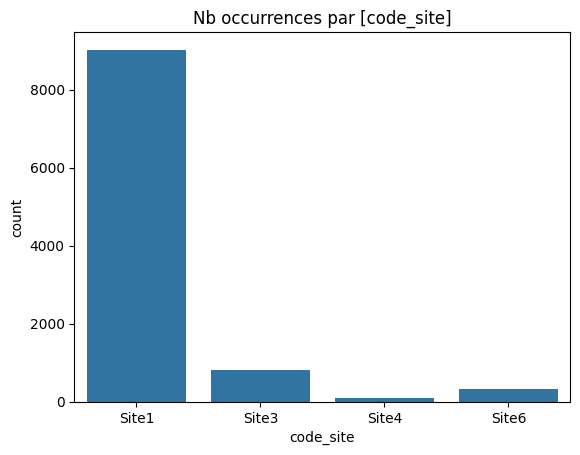

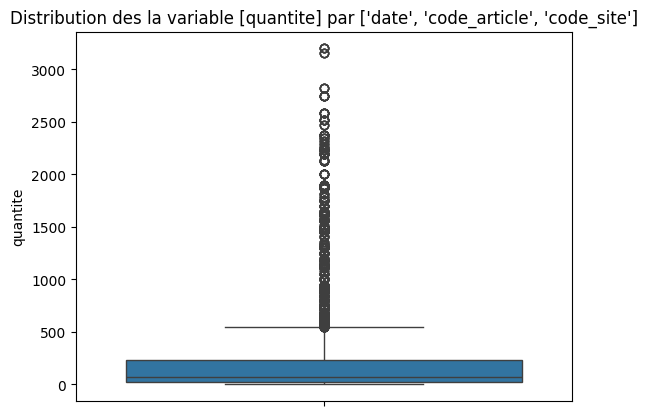

In [93]:
## Analyse de la variable qualitative [code_site]
sns.countplot(x='code_site', data=df_ana)
plt.title("Nb occurrences par [code_site]")
plt.show()
# show(df_ana['code_site'].value_counts())

## Analyse de la variable quantitative agrégée [quantite]
cle = ['date', 'code_article', 'code_site']
sns.boxplot(y = df_ana.groupby(cle, as_index=False)['quantite'].sum()['quantite'])
plt.title(f"Distribution des la variable [quantite] par {cle}")
plt.show()

## Affichage valeurs extrèmes
# show(df_ana[(df_ana.groupby(cle)['quantite'].transform('sum') > 3000)])

In [94]:
## Sauvegarde du dataframe pour croisement champs communs avec autres tables
df_ventes = df_ana.copy()
df_ventes['src_ventes'] = True

## 4. Champs communs

#### a) Sites

In [128]:
dfs = {
    "stocks": df_stocks,
    "ventes": df_ventes,
    "appros": df_appros,
}

for i, (name, df) in enumerate(dfs.items()):
    df_temp = (df.groupby(['code_site', f"src_{name}"], as_index=False)
               ['quantite'].sum()
               .rename({'quantite' : name}, axis=1))
    if i == 0:
        df_ana = df_temp.copy()
    else:
        df_ana = df_ana.merge(df_temp, on='code_site', how='outer')

col_obj = df_ana.select_dtypes(include="object", exclude='str').columns
col_num = df_ana.select_dtypes(include=['int', 'float']).columns
df_ana[col_obj] = df_ana[col_obj].fillna(False).astype('bool')
df_ana[col_num] = df_ana[col_num].fillna(0).astype('int')

cols = ['code_site'] + col_obj.tolist() + col_num.tolist()
show(df_ana[cols])

Loading ITables v2.7.0 from the internet... (need help?)


#### b) Articles

In [137]:
# Conservation uniquement des sites 1 et 2 pour analyse article
dfs = {
    "stocks": df_stocks,
    "ventes": df_ventes,
    "appros": df_appros,
}

for i, (name, df) in enumerate(dfs.items()):
    cond = (df['code_site'].isin(['Site1', 'Site3']))
    df_temp = (df[cond].groupby(['code_site', 'code_article', f"src_{name}"], as_index=False)
               ['quantite'].sum()
               .rename({'quantite' : name}, axis=1))
    if i == 0:
        df_ana = df_temp.copy()
    else:
        df_ana = df_ana.merge(df_temp, on=['code_site', 'code_article'], how='outer')

col_obj = df_ana.select_dtypes(include="object", exclude='str').columns
col_num = df_ana.select_dtypes(include=['int', 'float']).columns
df_ana[col_obj] = df_ana[col_obj].fillna(False).astype('bool')
df_ana[col_num] = df_ana[col_num].fillna(0).astype('int')

# 1er affichage sortie
cols = ['code_site', 'code_article'] + col_obj.tolist() + col_num.tolist()
show(df_ana[cols])

# Affichage comptage résultats
df_ana['cas'] = np.where(
    df_ana[col_obj].all(axis=1),
    'Présent dans toutes les sources',
    'Non présent dans toutes les sources'
)

cols = ['code_site', 'cas'] + col_obj.tolist()
show(df_ana.groupby(cols, as_index=False)['code_article'].count())

show(df_ana.groupby('code_site')['cas'].value_counts(normalize=True).reset_index())


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


#### c) Période / date

In [ ]:
# Conservation uniquement des sites 1 et 3 pour analyse période
dfs = {
    "ventes": df_ventes,
    "appros": df_appros,
}

for nom, df in dfs.items():
    cond = (df['code_site'].isin(['Site1', 'Site3']))
    print(f"""Période couverte {nom}:
    date min : {df[cond]['date'].min()}
    date_max : {df[cond]['date'].max()}""")

Période couverte ventes:
    date min : 2026-02-09
    date_max : 2026-12-28
Période couverte appros:
    date min : 2026-02-09
    date_max : 2026-10-20
